# Sentiment Analysis using BERT

The following figure shows how we fine-tune the pre-trained BERT model for a sentiment analysis task:

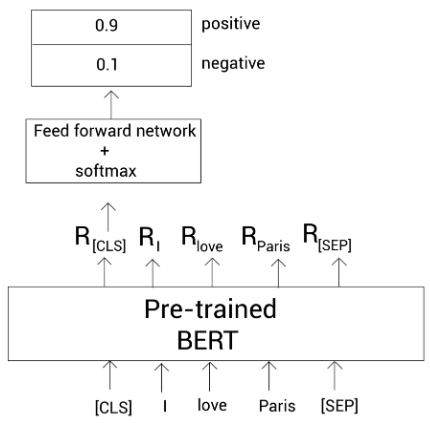    

As we can observe from the preceding figure, we feed the tokens to the pre-trained BERT model and get the embeddings of all the tokens. We take the embedding of the [CLS] token and feed it to a feedforward network with a softmax function and perform classification.

In [1]:
!pip install nlp==0.4.0
!pip install transformers==4.30.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [21]:
!pip install dill==0.3.5.1

  Using cached dill-0.3.5.1-py2.py3-none-any.whl.metadata (9.7 kB)
Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.16 requires dill>=0.3.8, but you have dill 0.3.5.1 which is incompatible.


In [32]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1


# Import Necessary Libraries 

In [2]:
from transformers import BertForSequenceClassification, BertTokenizerFast,Trainer, TrainingArguments
from nlp import load_dataset
import torch
import numpy as np

# Loading the dataset

In [3]:
!gdown https://drive.google.com/uc?id=11_M4ootuT7I1G0RlihcC0cA3Elqotlc-
dataset = load_dataset('csv', data_files='./imdbs.csv', split='train')

Downloading...
From: https://drive.google.com/uc?id=11_M4ootuT7I1G0RlihcC0cA3Elqotlc-
To: /content/imdbs.csv
100% 132k/132k [00:00<00:00, 59.5MB/s]


In [4]:
type(dataset)

nlp.arrow_dataset.Dataset

In [5]:
import nlp
nlp.arrow_dataset.Dataset

nlp.arrow_dataset.Dataset

# Creating train and test sets

In [6]:
dataset = dataset.train_test_split(test_size=0.3)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 70),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 30)}

In [8]:
train_set = dataset['train']
test_set = dataset['test']

# Loading the BERT model and tokenizer

In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.pr

In [10]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Preprocessing the dataset

In [11]:
sentence = 'I love Paris'

In [12]:
tokens = tokenizer.tokenize(sentence)
print(tokens)

['i', 'love', 'paris']


In [13]:
tokens = ['[CLS]'] + tokens + ['[SEP]']
print(tokens)

['[CLS]', 'i', 'love', 'paris', '[SEP]']


In [14]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[101, 1045, 2293, 3000, 102]


In [15]:
token_type_ids = [0, 0, 0, 0, 0]

In [16]:
attention_mask = [1, 1, 1, 1, 1]

# Preprocessing the dataset using a tokenizer

In [17]:
tokenizer('I love Paris')

{'input_ids': [101, 1045, 2293, 3000, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [18]:
tokenizer(['I love Paris', 'birds fly','snow fall'], padding = True, max_length=5)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'input_ids': [[101, 1045, 2293, 3000, 102], [101, 5055, 4875, 102, 0], [101, 4586, 2991, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]}

In [19]:
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

# Preprocessing the train and test sets

In [20]:
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Training the model

In [21]:
batch_size = 8
epochs = 2
warmup_steps = 500
weight_decay = 0.01

In [22]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./logs',
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set
)

In [24]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.686378
2,No log,0.682015


TrainOutput(global_step=18, training_loss=0.6940735181172689, metrics={'train_runtime': 1276.8239, 'train_samples_per_second': 0.11, 'train_steps_per_second': 0.014, 'total_flos': 36835547750400.0, 'train_loss': 0.6940735181172689, 'epoch': 2.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.6820146441459656,
 'eval_runtime': 71.5173,
 'eval_samples_per_second': 0.419,
 'eval_steps_per_second': 0.056,
 'epoch': 2.0}